#### Project: Implement VGG-16 Architecture for training a dog vs cat classifier

#### Packages selection
- The first things is to import all the neccesary packages needed for this project

In [1]:
import time
import os
import numpy as np
import numpy as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Select GPU if available
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

#### Settings
- Configure the device
- Define all the hyperparameters to be used and needed to be tuned to achive a better accuracy
- Load and explore the data

In [2]:
# device

DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS =  100
BATCH_SIZE = 32

# Architecture model parameters
NUM_CLASSES = 2 # Binary classifier

In [3]:
# Dataset in the training set

num_train_cats = len([i for i in os.listdir(os.path.join('data', 'train'))
                     if i.endswith('.jpg') and i.startswith('cat')])
num_train_dogs = len([i for i in os.listdir(os.path.join('data','train'))
                     if i.endswith('.jpg') and i.startswith('dog')])

print(f'Training set cats:{num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

Training set cats:10000
Training set dogs: 10000


In [4]:
# Dataset in the validation set

num_valid_cats = len([i for i in os.listdir(os.path.join('data', 'valid'))
                     if i.endswith('.jpg') and i.startswith('cat')])
num_valid_dogs = len([i for i in os.listdir(os.path.join('data','valid'))
                     if i.endswith('.jpg') and i.startswith('dog')])

print(f'Training set cats:{num_valid_cats}')
print(f'Training set dogs: {num_valid_dogs}')

Training set cats:2500
Training set dogs: 2500


(262, 349, 3)


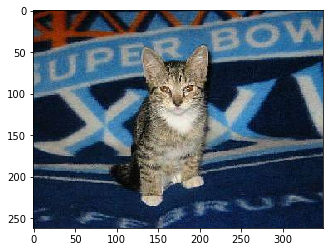

In [5]:
img = Image.open(os.path.join('data','train','cat.3000.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

### creating validation and test subset

In [6]:
if not os.path.exists(os.path.join('data', 'test')):
    os.mkdir(os.path.join('data', 'test'))
    
if not os.path.exists(os.path.join('data', 'valid')):
    os.mkdir(os.path.join('data', 'valid'))

#### Normalizing the data by subtracting the means and divide by standard deviation

In [ ]:
class CatsDogsDataset(Dataset):
    """Custom dataset loaading"""
    
    def __init__(self, img_dir, transform=None):
        
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir)
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
                
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                     self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
    def __len__(self):
        return len(self.y)
    
custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                       transforms.ToTensor()])

train_dataset = CatsDogsDataset(img_dir=os.path.join('data', 'train'),
                               transform=custom_transform1)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=5000,
                          shuffle=False)

train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean', train_mean)
print('Standard Deviation', train_std)

#### DataLoader

In [ ]:
data_tranforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    }

train_dataset = CatsDogsDataset(img_dir=os.path.join('data', 'train'),
                              transform=data_tranforms['train'])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = CatsDogsDataset(img_dir=os.path.join('data', 'valid'),
                               transform=data_tranforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

test_dataset = CatsDogsDataset(img_dir=os.path.join('data', 'test'),
                              transform=data_tranforms['valid'])

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

#### Define the architecture of the model such as
- The number of input layers; which is determined by the features of the data
- Number of total hidden layers in the model consist of Convolution layers, Pooling layers and fully connected layers
- The output layer node units is determined by the intended outcome to achieve

In [ ]:
class VGG16(nn.Module):
    
    def __init__(self, NUM_CLASSES):
        super(VGG16, self).__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                     out_channels=64,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                     out_channels=64,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                        stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                     out_channels=128,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                     out_channels=128,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                        stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                     out_channels=256,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                     out_channels=256,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                     out_channels=256,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                     out_channels=256,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                    stride=(2, 2))
        )
        
        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                     out_channels=512,
                     kernel_size=(3,3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3),
                        stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                     out_channels=512,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                        stride=(2, 2))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, NUM_CLASSES)
        )
        
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        
        outputs = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(outputs, dim=1)
        
        return outputs, probas

#### Loss function and optimizer
- Instantiate the model
- define the specific Loss function to be used either cross entropy, MSELoss, etc
- define the optimization algorithm to be used either SGD, Adam, RMSprop, Momentum etc.

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(NUM_CLASSES).to(DEVICE)
optimzier = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### compute accuracy
- A function to compute train and test accuracy

In [ ]:
def compute_accuracy(model, data_loader):
    correct_predictions, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, labels) in enumerate(data_loader):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        
        output, probas = model(features)
        cross_entropy = F.cross_entropy(outputs, labels).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / num_examples * 100, cross_entropy/num_examles

#### Training a model requires the following steps
- Reset all the gradients to zero (0)
- Make a forward pass (make a prediction)
- Calculate the loss
- Perform back propagation
- Update all the parameters (weight and biases)

In [ ]:
start_time = time.time()
total_step = len(train_loader)
train_acc_list, valid_acc_list = [], []
train_loss_list, valid_loss_list = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    
    for i, (features, labels) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs, probas = model(features)
        loss = F.cross_entropy(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        if not i % 120:
            print(f'Epoch: {epoch+1:03d}/ {NUM_EPOCHS:03d} | '
                 f'Batch {i:03d} / {total_step:03d} |'
                 f'Loss: {loss:.4f}')
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy(model, train_loader)
        valid_acc, valid_loss = compute_accuracy(model, valid_loader)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc: {train_acc:.2f}%'
             f' | Validation Acc: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time Elapsed: {elapsed:.2f} min')
    
elapsed = (time.time() - start_time)/60
print(f'Total Training time: {elapsed:.2f} min')